In [2]:
import os
# start the notebook in the root of the git repo, so that we can import our stuff
if os.getcwd().split('/')[-1] == 'notebooks':
    os.chdir('..')

from src.simulation.sim import *
from src.simulation.initsim import gen_prior_param, init_simulation
from src.cli.simulations import first_k_with_value_then_random, flist_to_str
from src.simulation.graphs import *
from src.simulation.runsim import run_ensemble, run_simulation, make_progress
%matplotlib inline
%load_ext autoreload
%autoreload 2
import scipy as sp
import matplotlib as mpl

mpl.rcParams["figure.dpi"] = 300

from src.simulation.sim import *
from src.analyse.analyse import *
# import graph_tool as gt
import pandas as pd
import powerlaw as pl
import plotly.io as pio
from scipy.optimize import curve_fit
pio.renderers.default = 'notebook_connected'
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple, defaultdict
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib as mpl
import graph_tool.all as gt
mpl.rcParams["figure.dpi"] = 300


(ipykernel_launcher.py:85045): Gtk-WARNING **: 15:15:09.468: Locale not supported by C library.
	Using the fallback 'C' locale.


### Init graph

In [3]:
def show_graph(g):
    # draw the graph, labelling the edge weights by friendliness
    from graph_tool.draw import graph_draw
    edge_color_map = {-1.0: (199/255, 27/255, 0, 1),  # red
                    1.0: (0, 128/255, 255/255, 1),  # blue
                    0.0: (0, 0, 0, 0)}  # black
    edge_color = g.new_ep('vector<double>')
    for f, e in zip(g.ep.friendliness, g.edges()):
        edge_color[e] = edge_color_map[f]

    graph_draw(g, vertex_text=g.vertex_index, 
                # edge_text=g.ep.friendliness,
                edge_color=edge_color)


In [85]:
# FOR A NEW GRAPH
# ba_10 = gen_bba_graph(10,3,lambda:1)

# ba_10.save("ba_10")

ADJ =
$$[[0, 0, 0, 0, 1, 1, 1, 0, 0, 0] \\
[0, 0, 1, 1, 1, 1, 1, 1, 0, 0] \\
[0, 1, 0, 0, 1, 0, 1, 0, 0, 0] \\
[0, 1, 0, 0, 1, 0, 1, 1, 1, 0] \\
[1, 1, 1, 1, 0, 1, 1, 0, 1, 1] \\
[1, 1, 0, 0, 1, 0, 0, 0, 1, 0] \\
[1, 1, 1, 1, 1, 0, 0, 1, 1, 0] \\
[0, 1, 0, 1, 0, 0, 1, 0, 0, 1] \\
[0, 0, 0, 1, 1, 1, 1, 0, 0, 1] \\
[0, 0, 0, 0, 1, 0, 0, 1, 1, 0]] $$

In [4]:
ba_10 = gt.load_graph("ba_10.gt")

In [5]:
gt.adjacency(ba_10).toarray()

array([[0., 0., 0., 0., 1., 1., 1., 0., 0., 0.],
       [0., 0., 1., 1., 1., 1., 1., 1., 0., 0.],
       [0., 1., 0., 0., 1., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 1., 0., 1., 1., 1., 0.],
       [1., 1., 1., 1., 0., 1., 1., 0., 1., 1.],
       [1., 1., 0., 0., 1., 0., 0., 0., 1., 0.],
       [1., 1., 1., 1., 1., 0., 0., 1., 1., 0.],
       [0., 1., 0., 1., 0., 0., 1., 0., 0., 1.],
       [0., 0., 0., 1., 1., 1., 1., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 1., 1., 0.]])

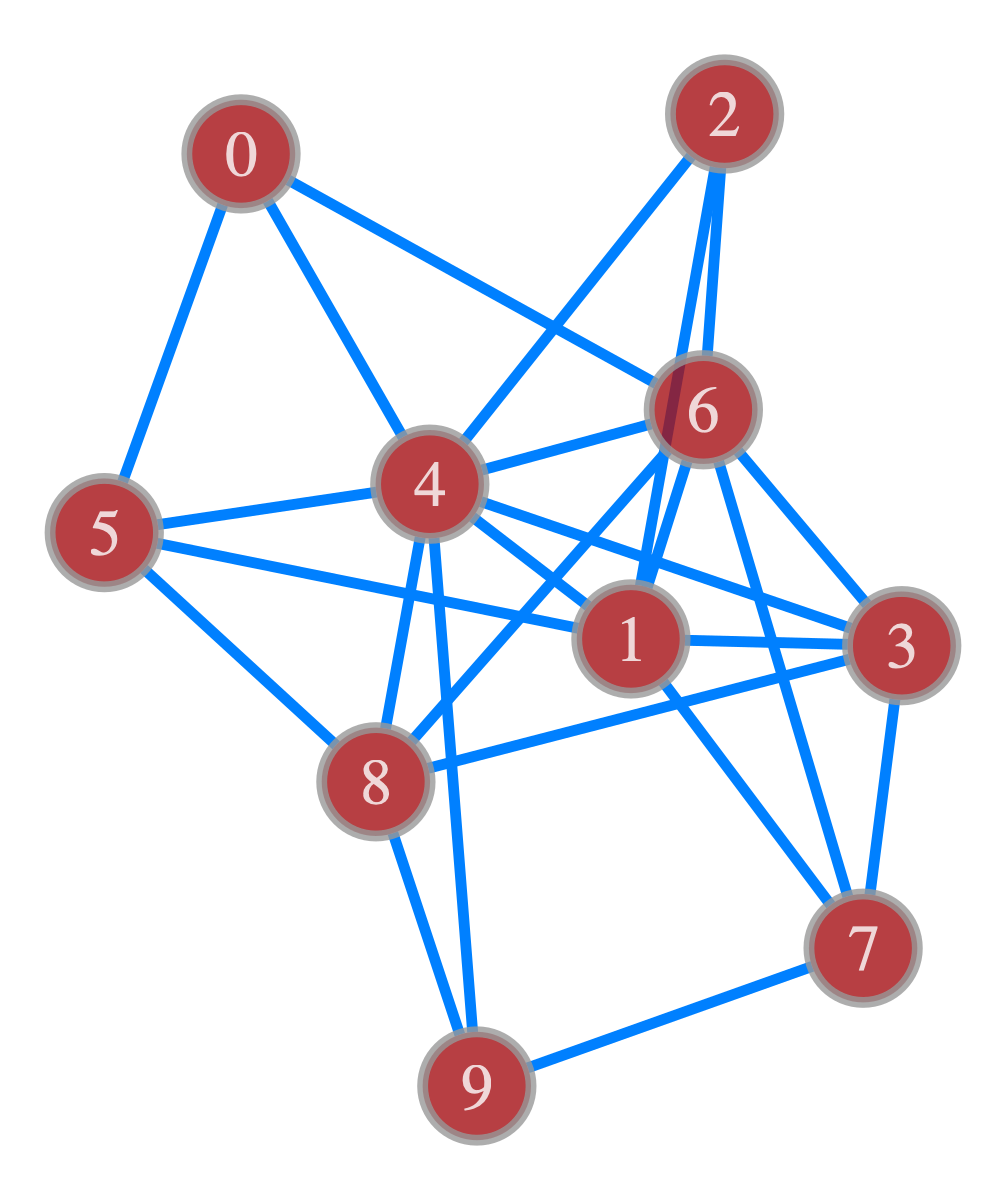

In [ ]:
show_graph(ba_10)

### Init sim

In [12]:
def k_at_index_else_random(partisan_val: int, partisan_list :list[int], n :int):
    # return a string, if the index is in partisan_list, return the partisan_val, else return 'r'
    return ",".join([str(partisan_val) if i in partisan_list else 'r' for i in range(n)])


In [13]:
# k_at_index_else_random(3, [1, 2,3],5)
# 'r,3,3,3,r'

In [184]:
# generate a coin list of 10000 with probability 0.6 of being head
coin_list = [1 if np.random.random() < bias else 0 for _ in range(10000)]
# save the coin list
np.save("coin_list", coin_list)

In [10]:
def gen_with_partisans(partisan_val: int, partisan_list: list[int], n, persuadable_range):
    val = k_at_index_else_random(partisan_val, partisan_list,n)
    return flist_to_str(gen_prior_param(val, n, range=persuadable_range))


In [205]:
disruption = [6]


Result = namedtuple('Result', ['partisans', "sims"])
Sim = namedtuple("Sim", ["asymptotic", "non_partisans_mean"])
n = 10
bias = 0.6           # theta0
partisan_mean = 0.3  # thetap
partisan_sd = 0.01

num_partisans = 1

max_steps = 10000
num_coins = 1
true_bias = bias
learning_rate = 0.25

frac_partisans = num_partisans / n



sim_params = dict(
    prior= {
        "mean": gen_with_partisans(partisan_mean, disruption, n, persuadable_range=(0, 1)),
        "sd": gen_with_partisans(partisan_sd, disruption, n, persuadable_range=(0.2, 0.8)),
        "n": n,
        "mean_range": (0, 1),
        "sd_range": (0.2, 0.8),
    },
    max_steps= max_steps,
    true_bias= bias,
    tosses_per_iteration= 1,
    learning_rate= learning_rate,
    asymptotic_learning_max_iters= 99,
    DWeps= 1,
    disruption= disruption,
    log= True,  # need to log to get mean_list
    coinslist= np.load("coin_list.npy")
,  # coin list needs to be None to have different simulations
    break_on_asymptotic_learning= False,
)

### Run sim


In [14]:
results_dict_list = []
for i in range(10):
    disruption = [i]


    Result = namedtuple('Result', ['partisans', "sims"])
    Sim = namedtuple("Sim", ["asymptotic", "non_partisans_mean"])
    n = 10
    bias = 0.6           # theta0
    partisan_mean = 0.3  # thetap
    partisan_sd = 0.01

    num_partisans = 1

    max_steps = 10000
    num_coins = 1
    true_bias = bias
    learning_rate = 0.25

    frac_partisans = num_partisans / n



    sim_params = dict(
        prior= {
            "mean": gen_with_partisans(partisan_mean, disruption, n, persuadable_range=(0, 1)),
            "sd": gen_with_partisans(partisan_sd, disruption, n, persuadable_range=(0.2, 0.8)),
            "n": n,
            "mean_range": (0, 1),
            "sd_range": (0.2, 0.8),
        },
        max_steps= max_steps,
        true_bias= bias,
        tosses_per_iteration= 1,
        learning_rate= learning_rate,
        asymptotic_learning_max_iters= 99,
        DWeps= 1,
        disruption= disruption,
        log= True,  # need to log to get mean_list
        coinslist= np.load("coin_list.npy")
    ,  # coin list needs to be None to have different simulations
        break_on_asymptotic_learning= False,
    )
    sim = run_simulation(ba_10, **sim_params)

    # fix the results -- namely some 
    # things that should be np.array but are lists of np.array

    results_dict = {k: v for k, v in zip(SimResults._fields, sim)}
    from src.analyse.results import results_array_params
    for k in results_array_params:
        results_dict[k] = np.asarray(results_dict[k])
    sim = SimResults(**results_dict)

    args = {
        "size": 10,
        "bias": bias,
        "disruption": disruption,
    }
    results_dict_list.append(sim)


### Analyse

In [15]:
def get_dist_and_step(self, threshold= 0.9, source = 0, theta = 0.6):
    sim = self.results
    sim_graph = read_graph(sim.adjacency, sim.friendliness)
    dist, _ = gt.search.dijkstra_search(sim_graph, sim_graph.edge_properties.friendliness, source=source)
    dist_per_node = list(map(int, dist.get_array()))
    pr_list = [np.sum(np.ndarray.flatten(self.calc_confidence_in_belief([theta])[:,i]) >= threshold) for i in range(len(self.results.initial_distr))]
    return sorted(list(zip(dist_per_node, pr_list)))



In [16]:
def indexof_belief(belief):
    try:
        return [round(x, 2) for x in np.linspace(0, 1, BIAS_SAMPLES)].index(belief)
    except ValueError:
        raise ValueError(f"Invalid belief θ={belief}")
    
def calc_confidence_in_belief(sim, beliefs: List[float]):
    beliefs_idx = [indexof_belief(belief) for belief in beliefs]        
    distr = sim.distrs.T[beliefs_idx].T # shape: (steps, n, len(beliefs))
    return distr

def get_steps_above_threshold(sim, threshold  = 0.9, theta = 0.6):  
    return [np.sum(np.ndarray.flatten(calc_confidence_in_belief(sim,[theta])[:,i]) >= threshold) for i in range(len(sim.distrs[0]))]

In [17]:
res = []
count = []
for i in range (10):
    res.append(get_steps_above_threshold(results_dict_list[i]))
    # count the number of 0, -1 from the partisan
    count.append(res[i].count(0) - 1)

In [18]:
res

[[0, 5060, 4975, 5507, 2277, 0, 2208, 5881, 4847, 5667],
 [2842, 0, 0, 268, 1173, 0, 881, 0, 3105, 3215],
 [4942, 1404, 0, 4985, 2345, 5140, 1939, 5103, 5472, 5670],
 [3959, 852, 3363, 0, 1636, 3668, 1134, 0, 499, 2924],
 [0, 388, 0, 184, 0, 0, 535, 2067, 0, 0],
 [0, 1404, 4347, 4447, 1719, 0, 4149, 5098, 748, 4345],
 [0, 436, 0, 96, 888, 2311, 0, 0, 326, 2423],
 [5154, 1213, 4302, 578, 4330, 5104, 1658, 0, 3936, 0],
 [3179, 3682, 3999, 520, 1323, 0, 1471, 3198, 0, 0],
 [5679, 5379, 5720, 4680, 2521, 5215, 5154, 0, 859, 0]]

In [19]:
mean = []
for i in range(10):
    m = [x for x in res[i] if x != i]
    mean.append(np.mean(m))

In [20]:
mean

[4552.75, 1148.4, 3700.0, 1803.5, 317.4, 2625.7, 648.0, 2627.5, 1737.2, 3520.7]

In [21]:
list(map(int, sum(gt.adjacency(ba_10).toarray()).tolist()))
[3, 6, 3, 5, 8, 4, 7, 4, 5, 3]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

[3, 6, 3, 5, 8, 4, 7, 4, 5, 3]

In [22]:
list(zip(list(map(int, sum(gt.adjacency(ba_10).toarray()).tolist())), mean,count))

[(3, 4552.75, 1),
 (6, 1148.4, 3),
 (3, 3700.0, 0),
 (5, 1803.5, 1),
 (8, 317.4, 5),
 (4, 2625.7, 1),
 (7, 648.0, 3),
 (4, 2627.5, 1),
 (5, 1737.2, 2),
 (3, 3520.7, 1)]

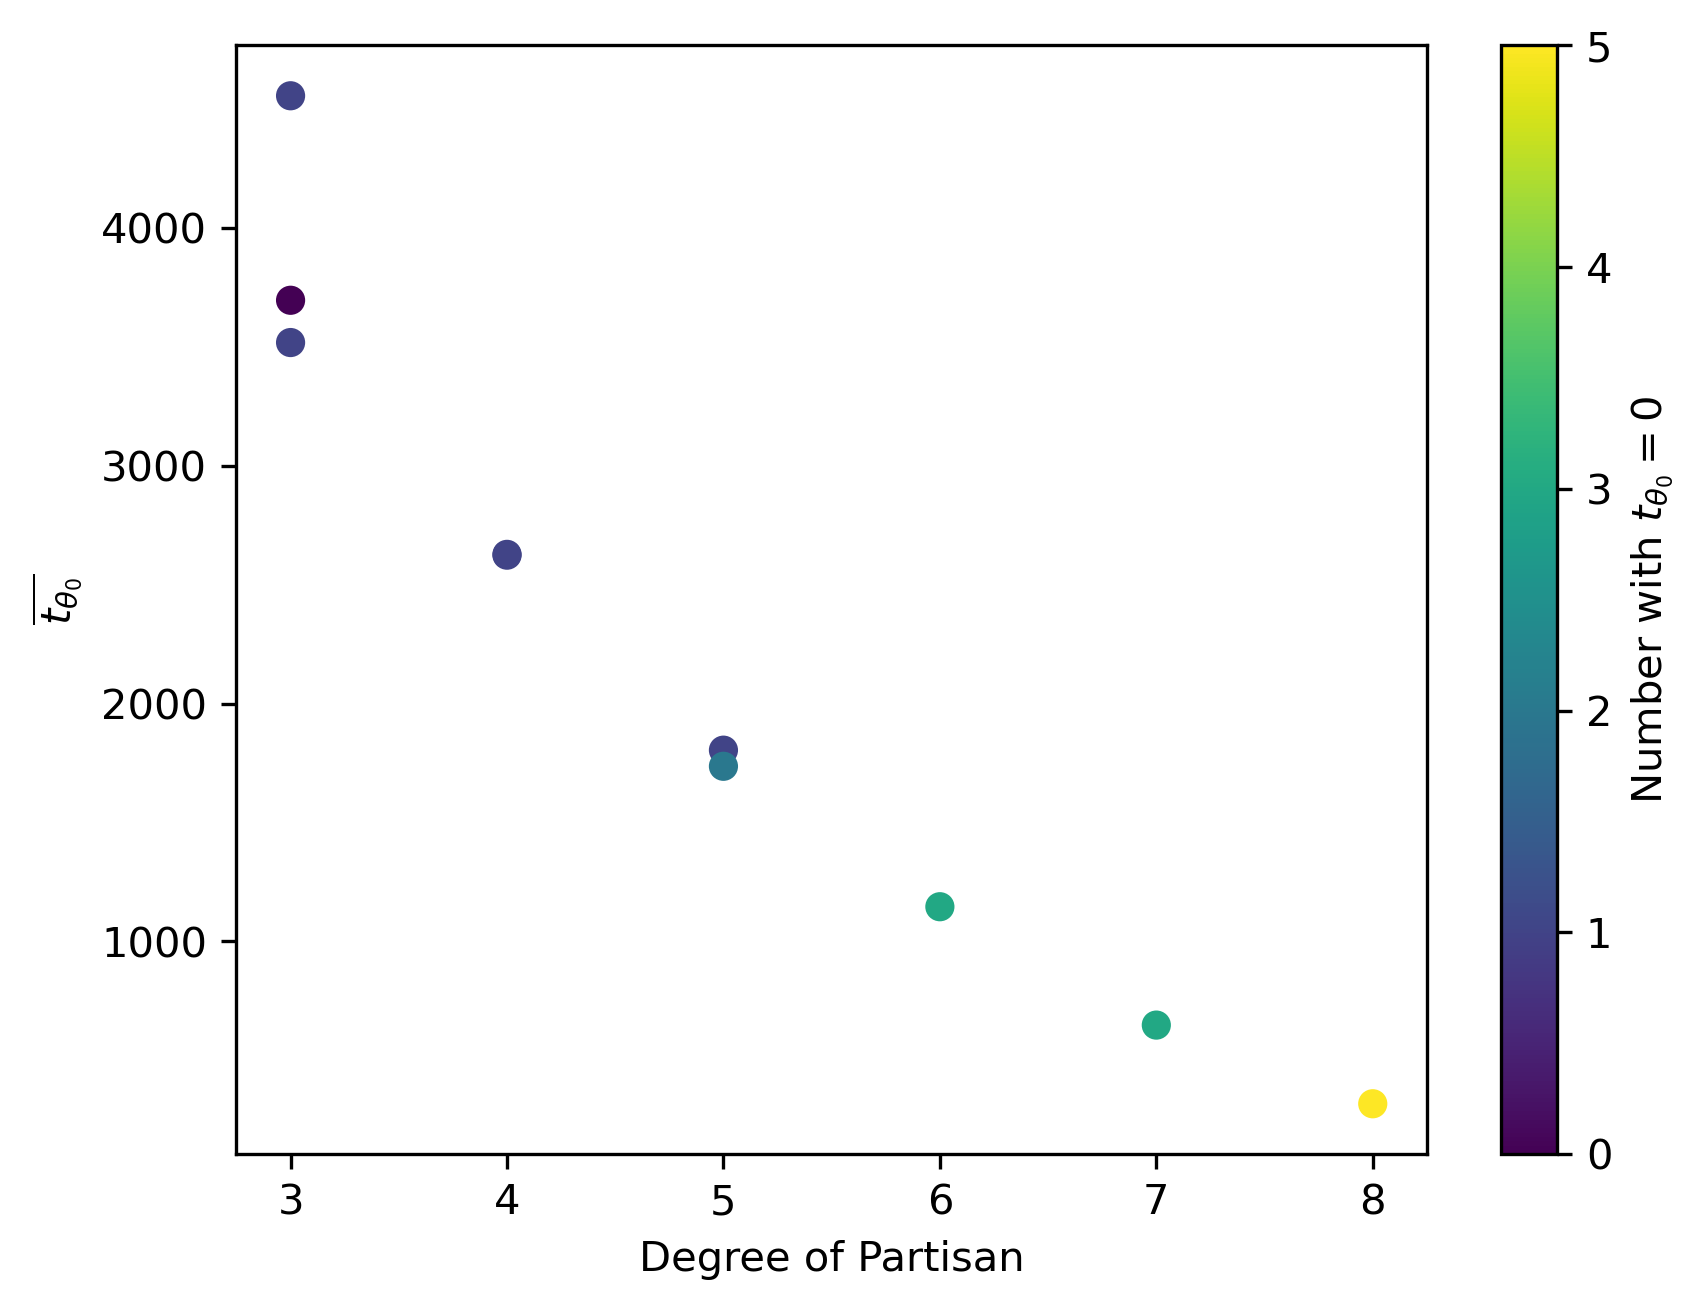

In [3]:
data = [(3, 4557.5, 1),
 (6, 1146.0, 3),
 (3, 3697.2, 0),
 (5, 1804.6, 1),
 (8, 317.1, 5),
 (4, 2628.3, 1),
 (7, 648.1, 3),
 (4, 2624.9, 1),
 (5, 1736.8, 2),
 (3, 3519.4, 1)]
        
# Splitting the data
degree = [d[0] for d in data]
t_theta_0 = [d[1] for d in data]
zeros = [d[2] for d in data]

plt.scatter(degree, t_theta_0, c=zeros)
plt.colorbar().set_label('Number with $t_{\\theta_0} = 0$')
plt.xlabel('Degree of Partisan')
plt.ylabel("$\\overline{t_{\\theta_0} }$")
plt.show()


In [48]:
lst = results_dict_list[0].mean_list[-1].tolist()
lst.pop(0)
lst

[0.5277994986266034,
 0.5261424145586484,
 0.533405702484574,
 0.5038822796901,
 0.47650511897778614,
 0.5055944166869227,
 0.5385134977761662,
 0.5251245341706965,
 0.5355498608081055]

In [63]:
degrees = list(map(int, sum(gt.adjacency(ba_10).toarray()).tolist()))
mean_end = []
for i in range (10):
    res = results_dict_list[i].mean_list[-1].tolist()
    res.pop(i)
    mean_end.append((res, degrees[i]))
mean_end[2][-1]

([0.5243439705820382,
  0.49317892904642807,
  0.5251408608802995,
  0.5045951562165109,
  0.5272223360654122,
  0.4991968079316467,
  0.5268937724183781,
  0.5316519603231231,
  0.5344304482344988],
 3)

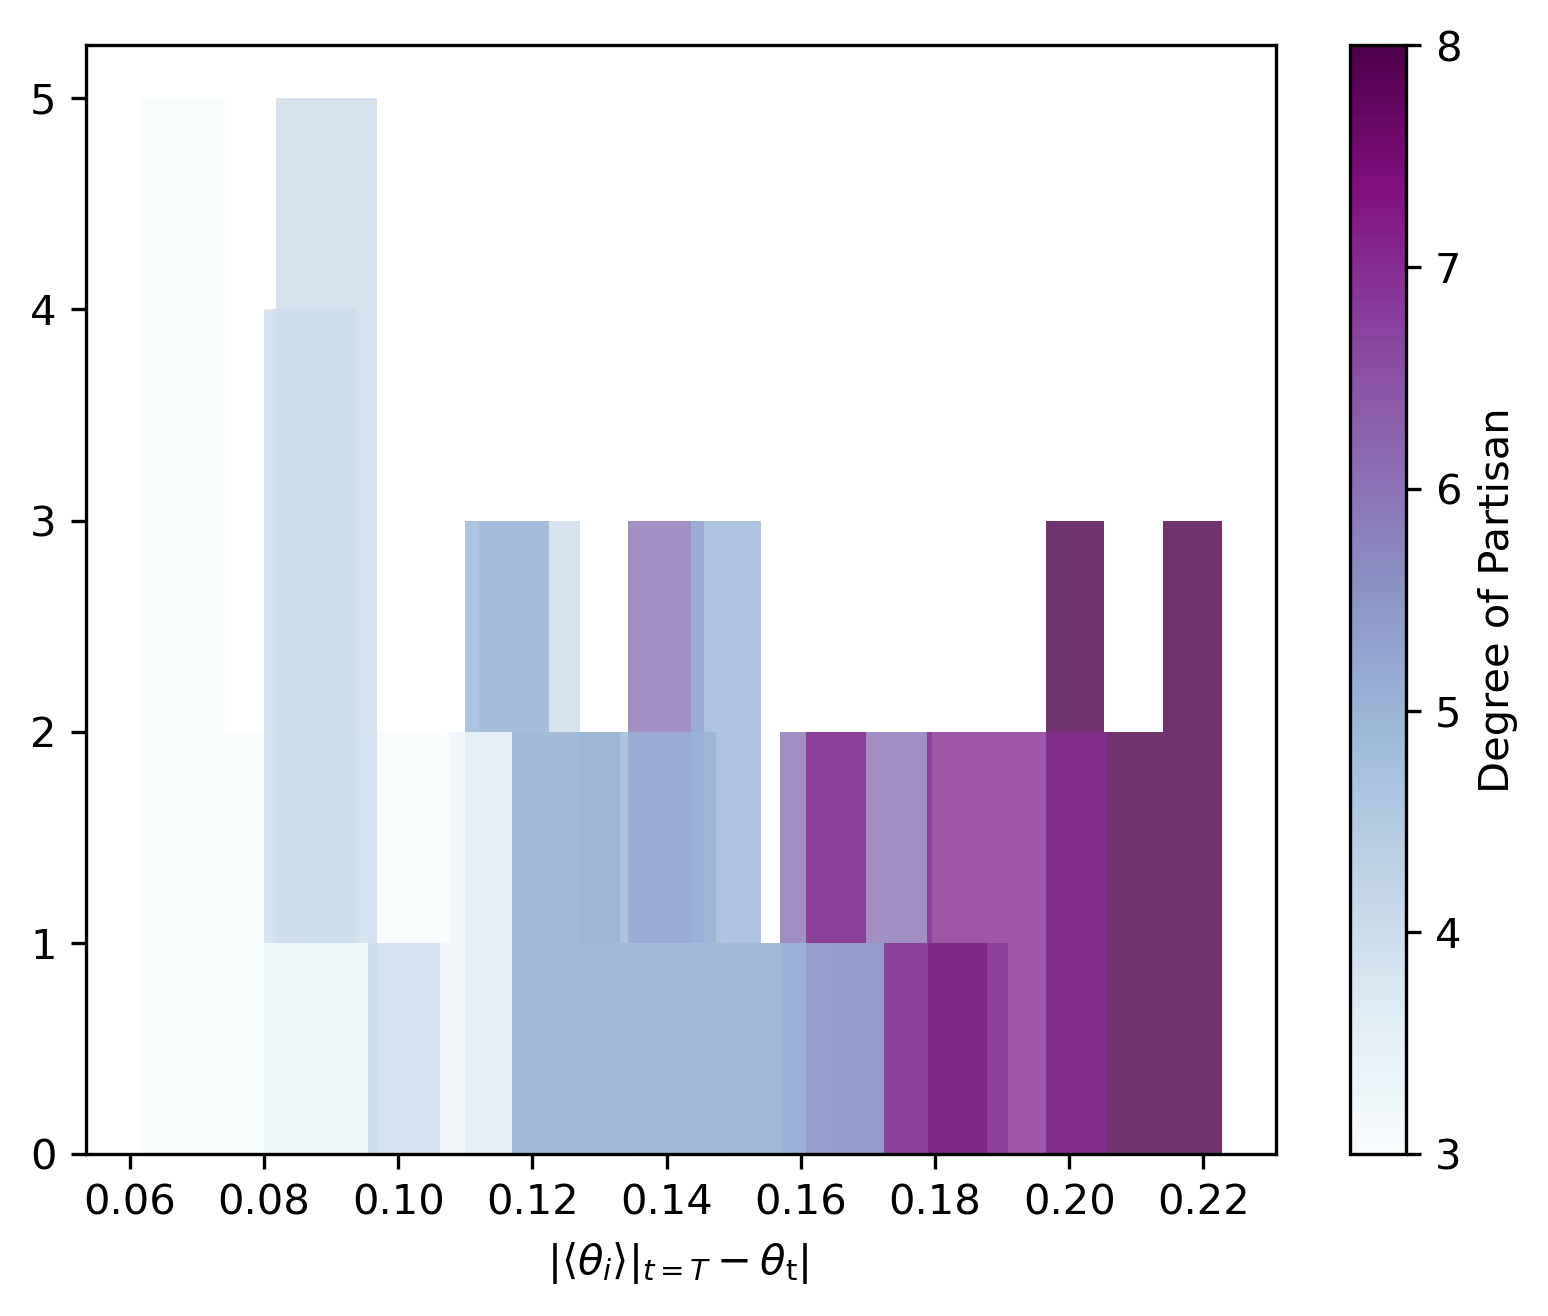

In [172]:
import matplotlib
import matplotlib.colors as mcolors

theta_t = 0.6
cmap = 'BuPu'  # or any other sequential colormap
colors =[mean_end[i][-1] for i in range (10)]
norm = mcolors.Normalize(vmin = min(colors), vmax = max(colors))

for i in range (10):    
    color = plt.cm.get_cmap(cmap)(norm(colors[i]))
    # mean = [abs(x - theta_t) for x in mean_end[i][:-1]]
    plt.hist(np.abs(np.array(mean_end[i][:-1][0]) - theta_t), label= f"partisan {i}", alpha=0.8,color=color, bins="auto")
    # plt.legend()
    plt.xlabel("$ | \\langle \\theta_{i} \\rangle|_{t = T} - \\theta_{\\rm t}| $ ")

# Add a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, label='Degree of Partisan')

# size = 8
# plt.xticks(size=10)
# plt.yticks(size=10)


In [173]:
degrees = list(map(int, sum(gt.adjacency(ba_10).toarray()).tolist()))
mean_alltime = []
mean_alltime_i = []
for i in range (10):
    mean_alltime.append((np.ndarray.flatten(np.delete(results_dict_list[i].mean_list[:], i, 1)), degrees[i]))



(0.0, 0.32)

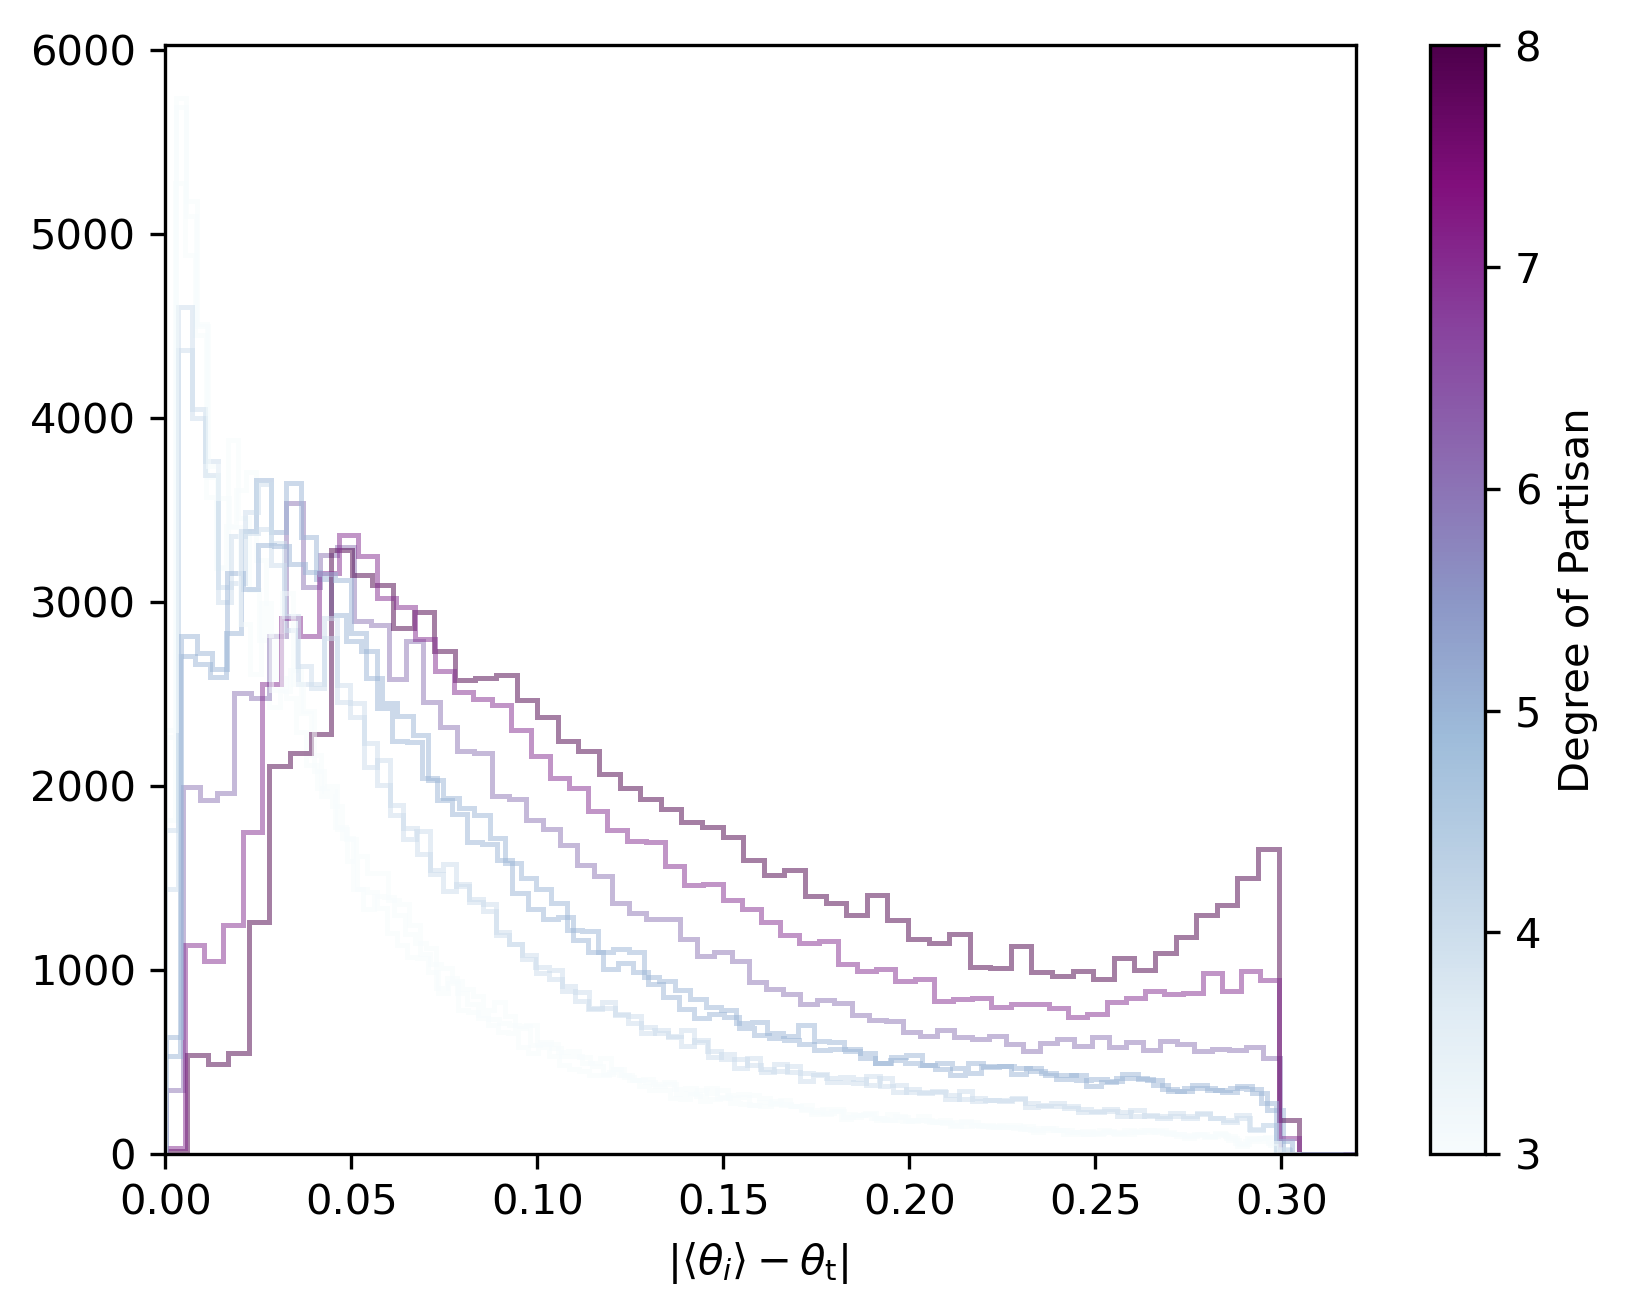

In [181]:
theta_t = 0.6
cmap = 'BuPu'  # or any other sequential colormap
colors =[mean_alltime[i][-1] for i in range (10)]
norm = mcolors.Normalize(vmin = min(colors), vmax = max(colors))

for i in range (10):    
    color = plt.cm.get_cmap(cmap)(norm(colors[i]))
    # mean = [abs(x - theta_t) for x in mean_end[i][:-1]]
    plt.hist(np.abs(np.array(mean_alltime[i][:-1][0]) - theta_t), label= f"partisan {i}", alpha=0.5,color=color, bins="auto", stacked=True, edgecolor=color, histtype=u'step', linewidth=1.2)
    # plt.legend()
    plt.xlabel("$ | \\langle \\theta_{i} \\rangle - \\theta_{\\rm t}| $ ")

# Add a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, label='Degree of Partisan')

# size = 8
# plt.xticks(size=10)
# plt.yticks(size=10)
# plt.yscale('log')
# plt.xscale('log')
plt.xlim(0.00, 0.32)

(array([1., 0., 0., 0., 2., 0., 0., 1., 2., 3.]),
 array([0.47650512, 0.48270596, 0.48890679, 0.49510763, 0.50130847,
        0.50750931, 0.51371015, 0.51991098, 0.52611182, 0.53231266,
        0.5385135 ]),
 <BarContainer object of 10 artists>)

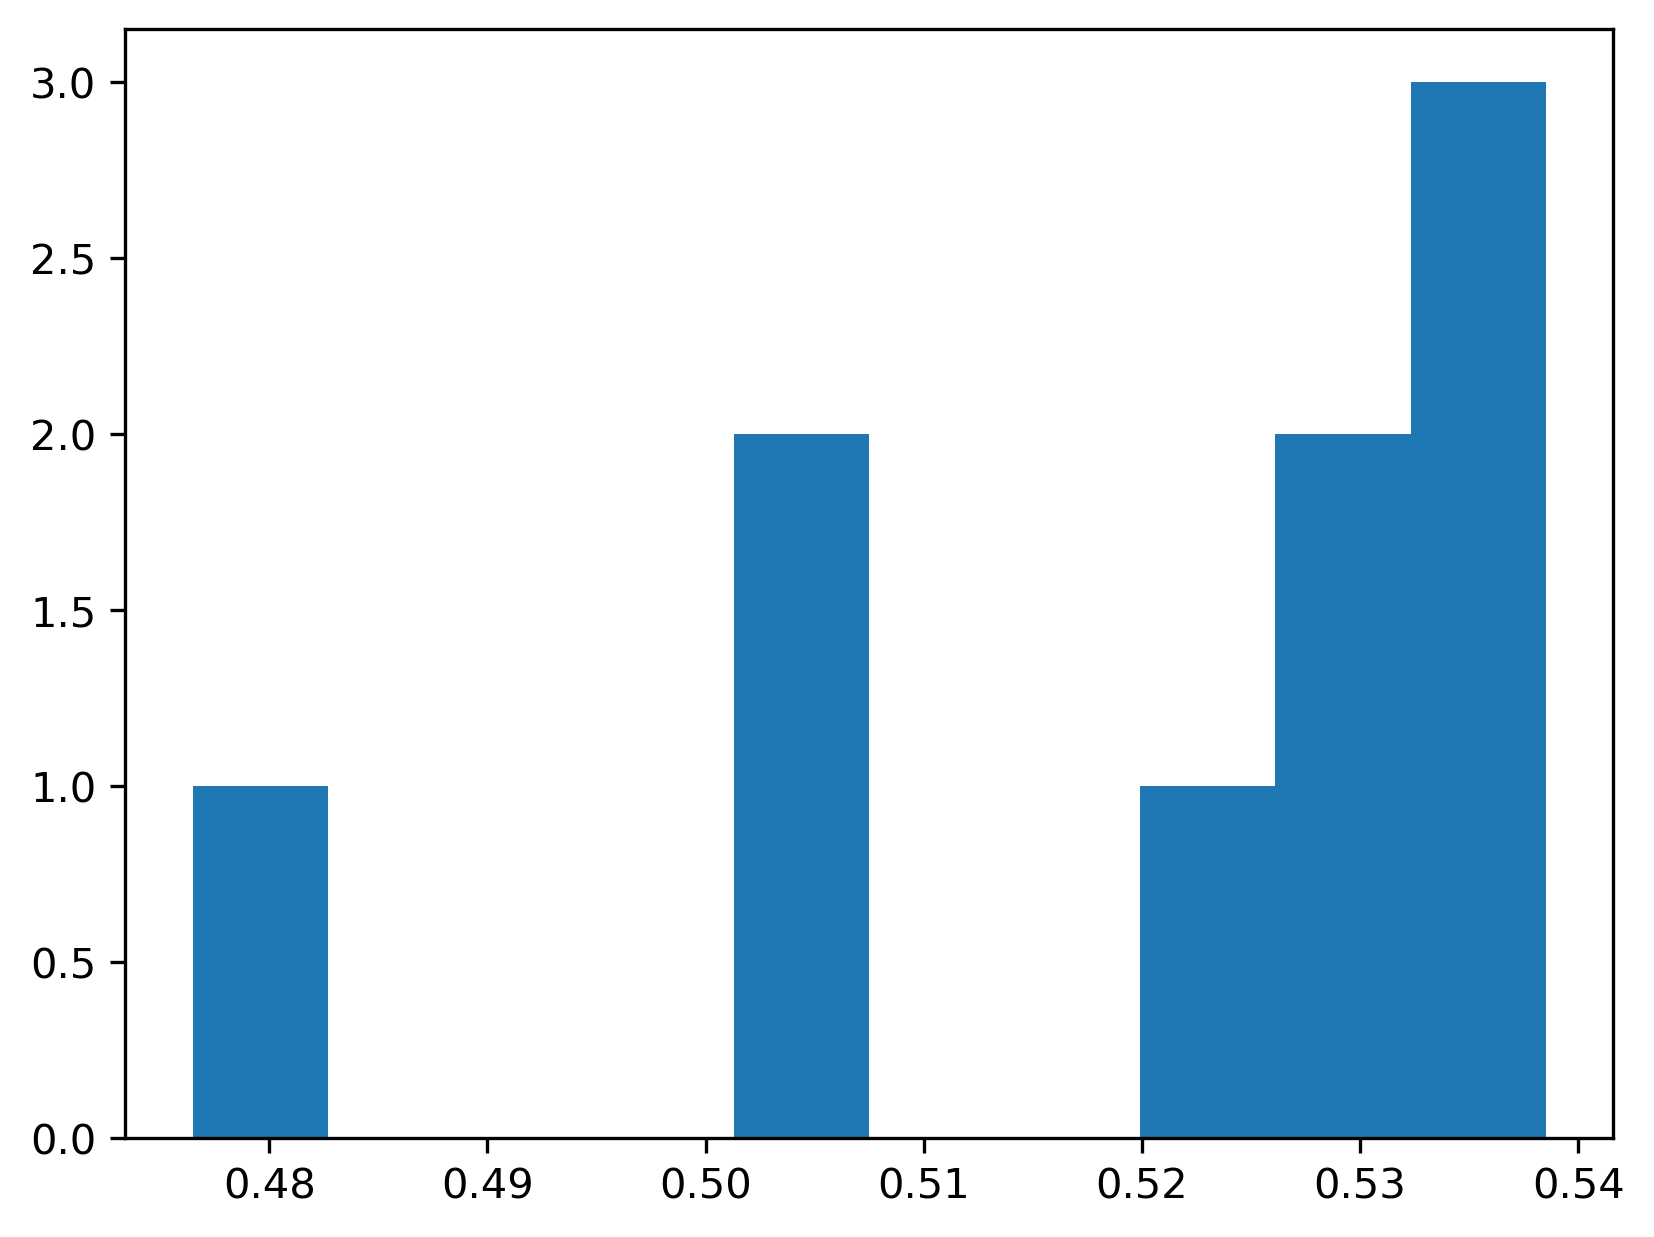

In [55]:
plt.hist(mean_end[0])

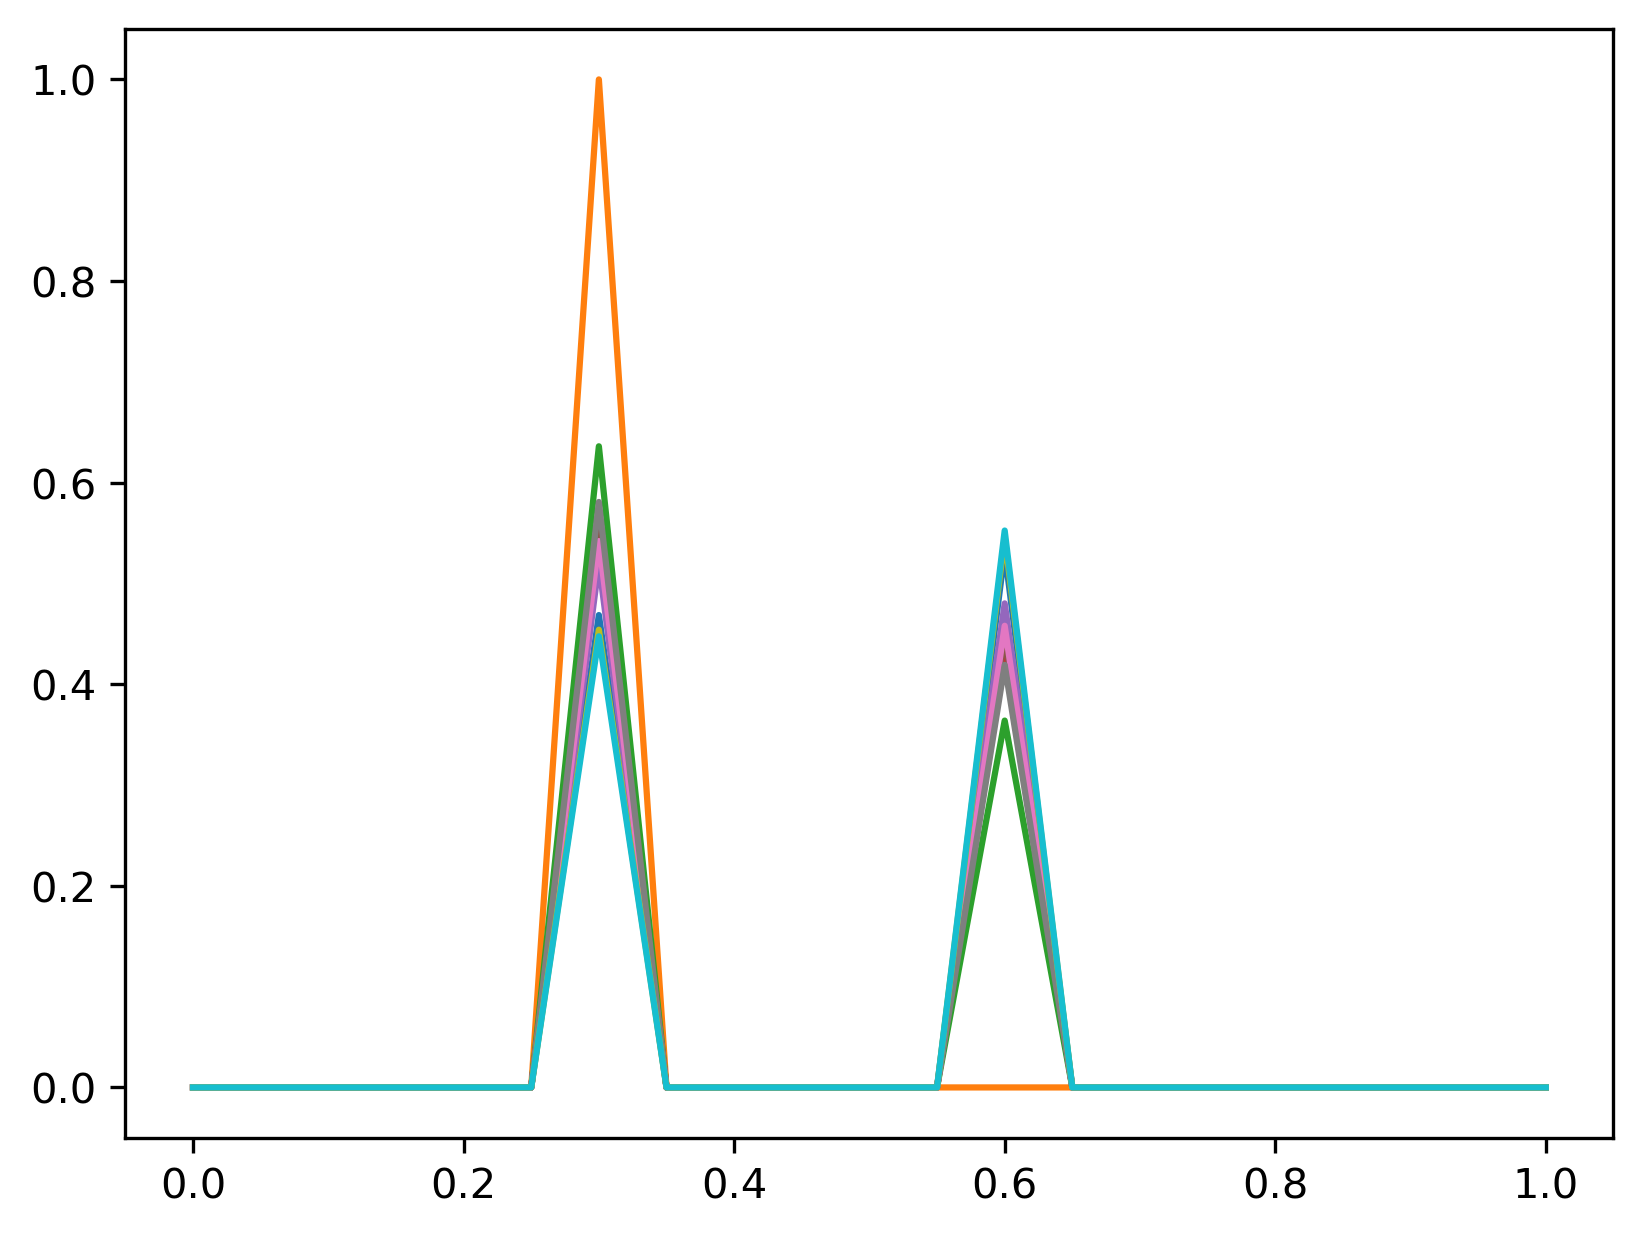

: 

In [184]:
plt.plot(np.linspace(0, 1, BIAS_SAMPLES), results_dict_list[1].distrs[-1].T)